In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random, os
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from itertools import combinations
from autogluon.tabular import TabularDataset, TabularPredictor
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'

d:\project\smoking_predict\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
seed_everything(seed)

In [67]:
path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [4]:
train.head()

,ID,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율,label
0,TRAIN_0000,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53,1
1,TRAIN_0001,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45,0
2,TRAIN_0002,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04,0
3,TRAIN_0003,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18,0
4,TRAIN_0004,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7000 non-null   object 
 1   나이        7000 non-null   int64  
 2   키(cm)     7000 non-null   int64  
 3   몸무게(kg)   7000 non-null   int64  
 4   BMI       7000 non-null   float64
 5   시력        7000 non-null   float64
 6   충치        7000 non-null   int64  
 7   공복 혈당     7000 non-null   int64  
 8   혈압        7000 non-null   int64  
 9   중성 지방     7000 non-null   int64  
 10  혈청 크레아티닌  7000 non-null   float64
 11  콜레스테롤     7000 non-null   int64  
 12  고밀도지단백    7000 non-null   int64  
 13  저밀도지단백    7000 non-null   int64  
 14  헤모글로빈     7000 non-null   float64
 15  요 단백      7000 non-null   int64  
 16  간 효소율     7000 non-null   float64
 17  label     7000 non-null   int64  
dtypes: float64(5), int64(12), object(1)
memory usage: 984.5+ KB


In [6]:
train.describe()

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율,label
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,43.973571,164.781429,65.932857,24.144423,1.011650,0.227429,99.331857,45.532857,127.144714,0.884900,197.276571,57.355429,115.346857,14.631914,1.083857,1.144696,0.367286
std,12.063793,9.170213,12.978702,3.501945,0.427828,0.419202,21.129670,8.820611,73.918492,0.241523,36.306494,14.506945,41.788153,1.540907,0.392051,0.432735,0.482100
min,20.000000,135.000000,30.000000,14.270000,0.100000,0.000000,57.000000,14.000000,21.000000,0.100000,86.000000,18.000000,1.000000,4.900000,1.000000,0.140000,0.000000
25%,35.000000,160.000000,55.000000,21.600000,0.800000,0.000000,89.000000,40.000000,74.000000,0.800000,173.000000,47.000000,92.000000,13.600000,1.000000,0.840000,0.000000
50%,40.000000,165.000000,65.000000,23.880000,1.000000,0.000000,96.000000,45.000000,107.000000,0.900000,195.000000,55.000000,113.000000,14.800000,1.000000,1.100000,0.000000
75%,50.000000,170.000000,75.000000,26.120000,1.200000,0.000000,104.000000,50.000000,161.000000,1.000000,219.000000,66.000000,136.000000,15.700000,1.000000,1.380000,1.000000
max,85.000000,190.000000,130.000000,42.450000,9.900000,1.000000,386.000000,91.000000,999.000000,10.000000,395.000000,157.000000,1340.000000,20.900000,5.000000,5.670000,1.000000


In [7]:
for col in ['충치', '요 단백']:
    display(train[col].unique())    

array([1, 0], dtype=int64)

array([1, 3, 2, 4, 5], dtype=int64)

In [8]:
train['충치'] = train['충치'].astype('category')
train['요 단백'] = train['요 단백'].astype('category') # 3+(300mg) -> 300mg 이상이면 단백뇨
test['충치'] = test['충치'].astype('category')
test['요 단백'] = test['요 단백'].astype('category')

In [68]:
def get_data(path='data/'):
    train = pd.read_csv(path + 'train.csv')
    test = pd.read_csv(path + 'test.csv')
    submission = pd.read_csv(path + 'sample_submission.csv')
    x_train = train.drop(['ID', 'label'], axis=1)
    y_train = train['label']
    x_test = test.drop('ID', axis=1)
    x_train['충치'] = x_train['충치'].astype('category')
    # x_train['요 단백'] = x_train['요 단백'].astype('category')
    x_test['충치'] = x_test['충치'].astype('category')
    # x_test['요 단백'] = x_test['요 단백'].astype('category')
    return x_train, y_train, x_test, submission

x_train, y_train, x_test, submission = get_data()

In [69]:
def baseline_predict(seeds, x=None, y=None, x_te=None, save=False, file_names=None):
    x_train, y_train, x_test, submission = get_data()
    if x is not None:
        x_train = x.copy()
    if y is not None:
        y_train = y.copy()
    if x_te is not None:
        x_test = x_te.copy()
    save_path = 'data/preprocess/submission_'
    models = []
    scores = [[] for _ in range(len(seeds))]
    
    for idx, sd in enumerate(seeds):
        model = LGBMClassifier(random_state=42)
        skf = StratifiedKFold(n_splits=5, random_state=sd, shuffle=True)
        fname = str(file_names[idx]) if file_names is not None else str(sd)      
        for train_idx, val_idx in skf.split(x_train, y_train):
            x_tr, x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model.fit(x_tr, y_tr)
            acc = np.round(accuracy_score(y_val, model.predict(x_val)), 4)
            scores[idx].append(acc)
        models.append(model)
        if save:
            predict = model.predict(x_test)
            submission['label'] = predict
            submission.to_csv(save_path + f'{fname}.csv', index=False)            
    return models, scores
        

In [28]:
# 0.7522222222
model, score = baseline_predict([5])
print(np.mean(score))
submission['label'] = model[0].predict(x_test)
submission.to_csv('data/preprocess/submission_no_cat.csv', index=False)

0.7261599999999999


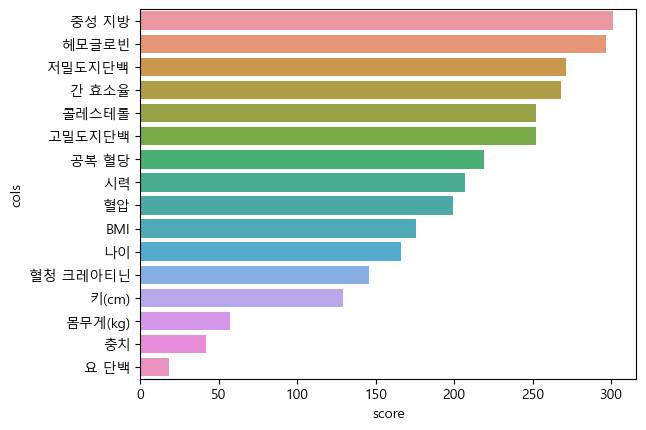

In [29]:
ftr = pd.DataFrame({'cols' : x_train.columns, 'score' : model[0].feature_importances_})
sns.barplot(x=ftr.sort_values('score', ascending=False)['score'], 
            y=ftr.sort_values('score', ascending=False)['cols'], orient='h')
plt.show()

In [54]:
model, score = baseline_predict([5], x=x_train.drop('요 단백', axis=1), y=y_train, x_te=x_test.drop('요 단백', axis=1))
print(np.mean(score))
# submission['label'] = model[0].predict(x_test)
# submission.to_csv('data/preprocess/submission_no_요단백.csv', index=False)

0.72516


In [55]:
model, score = baseline_predict([5], x=x_train.drop(['요 단백', '충치'], axis=1), y=y_train, x_te=x_test.drop(['요 단백', '충치'], axis=1))
print(np.mean(score))

0.728


In [58]:
model, score = baseline_predict([5], x=x_train.drop(['요 단백', '충치', '몸무게(kg)'], axis=1), y=y_train, x_te=x_test.drop(['요 단백', '충치', '몸무게(kg)'], axis=1))
print(np.mean(score))
submission['label'] = model[0].predict(x_test.drop(['요 단백', '충치', '몸무게(kg)'], axis=1))
submission.to_csv('data/preprocess/submission_no_요단백_충치_몸무게.csv', index=False)

0.7317


In [11]:
seeds = [5, 42, 1004]
models, scores = baseline_predict(seeds)
print(np.mean(scores, axis=1))
# 제출 스코어
# 5 : 0.7477777778
# 42 : 0.7288888889
# 1004 : 7255555556

[0.72714 0.72244 0.728  ]


<Axes: xlabel='label', ylabel='count'>

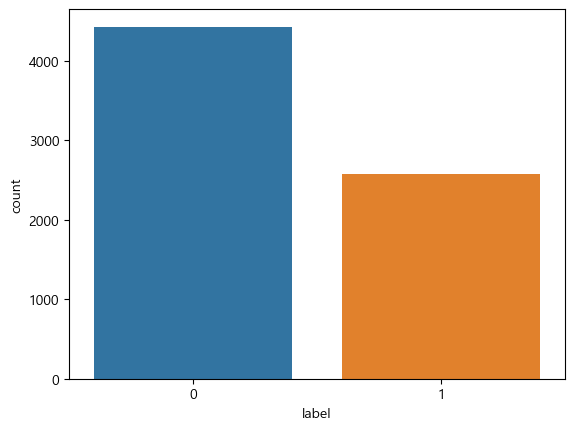

In [12]:
sns.countplot(x=y_train)

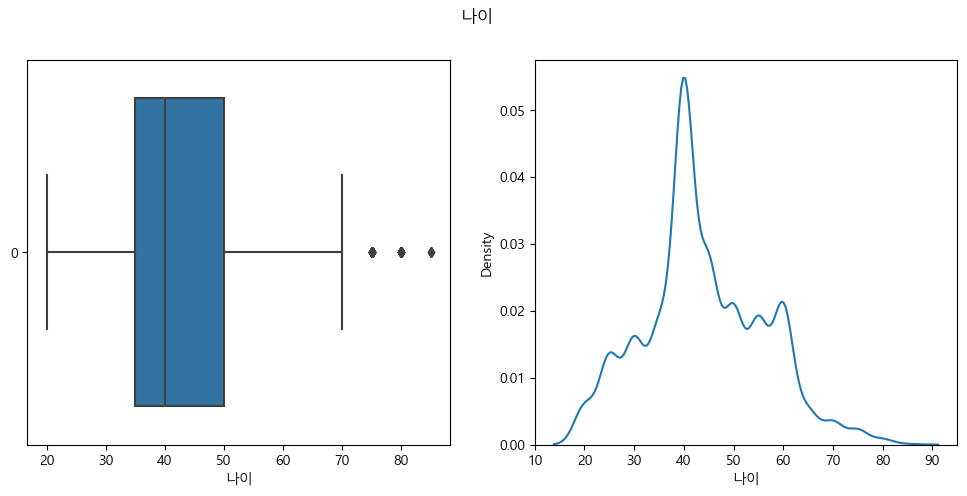

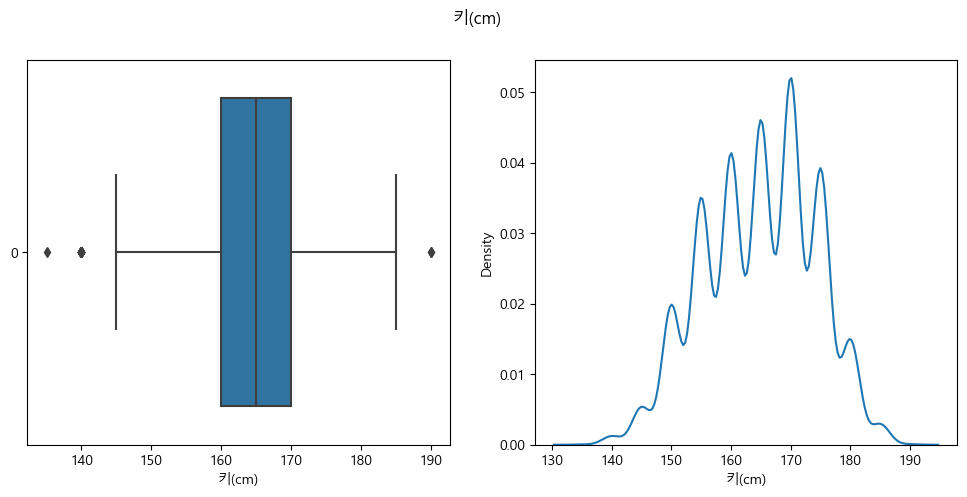

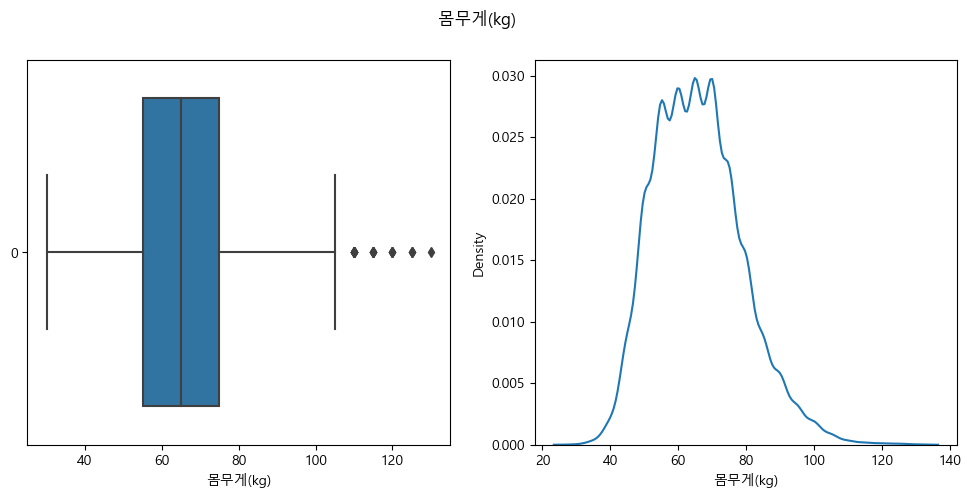

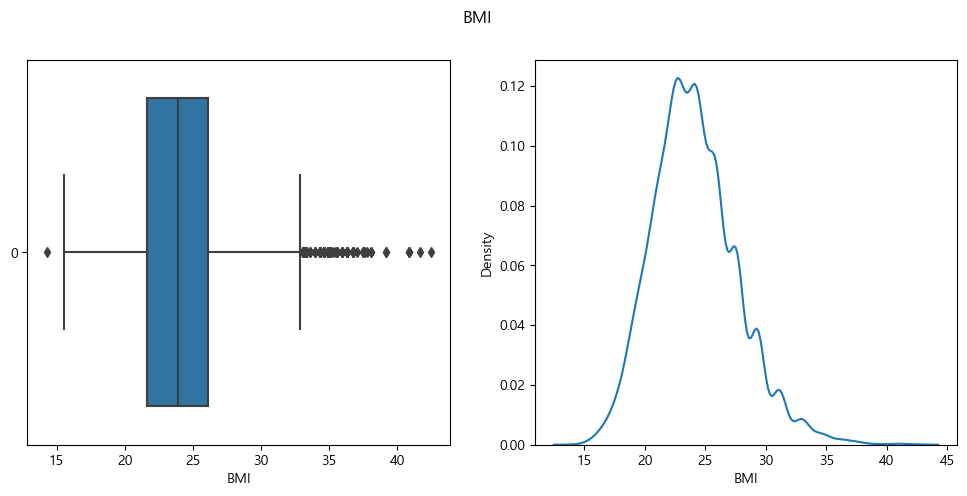

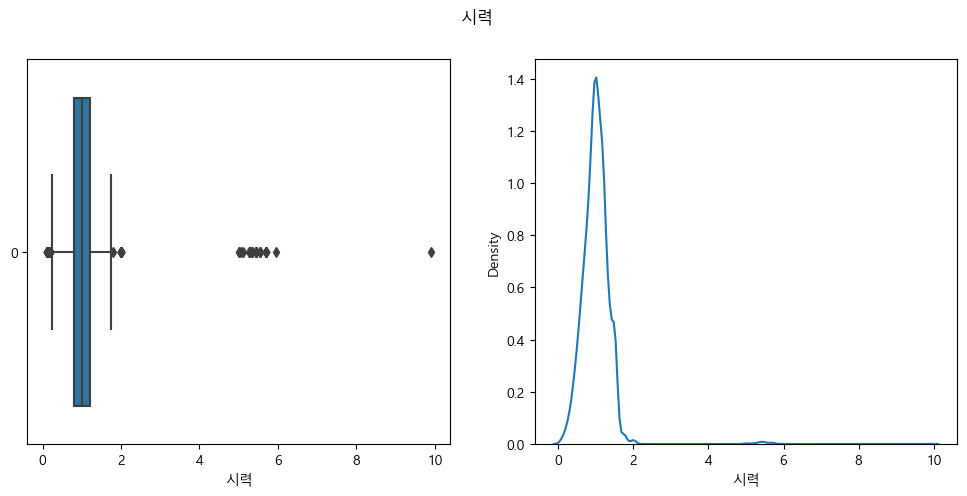

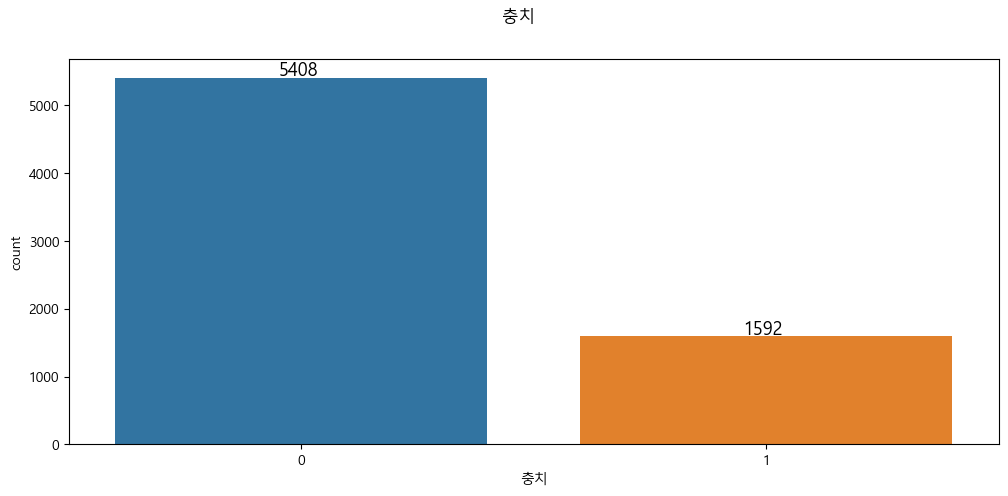

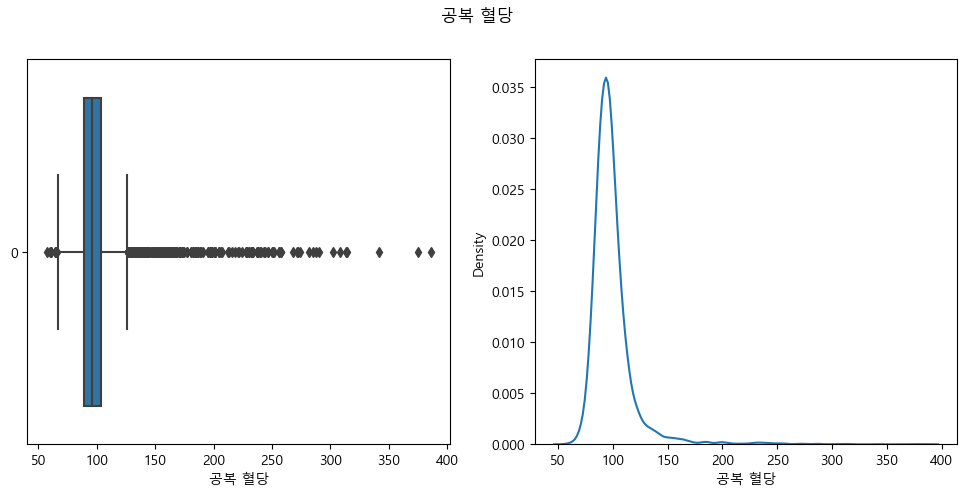

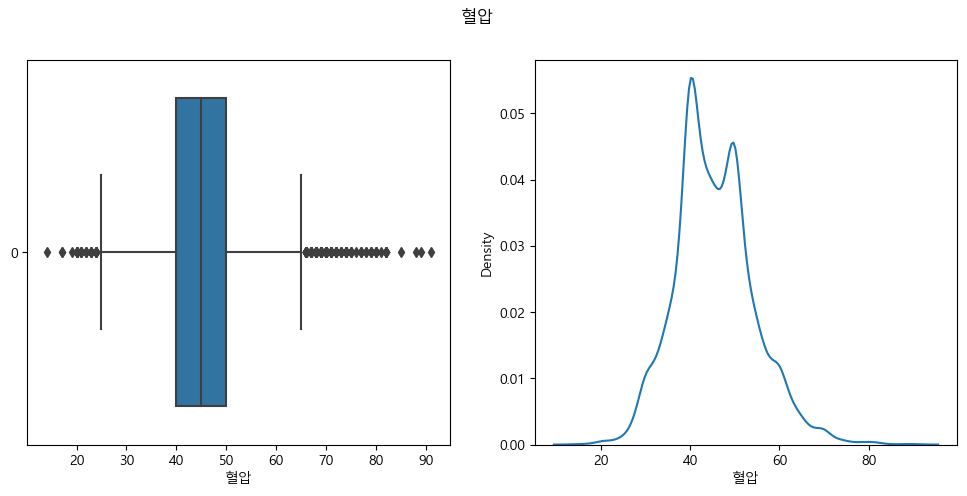

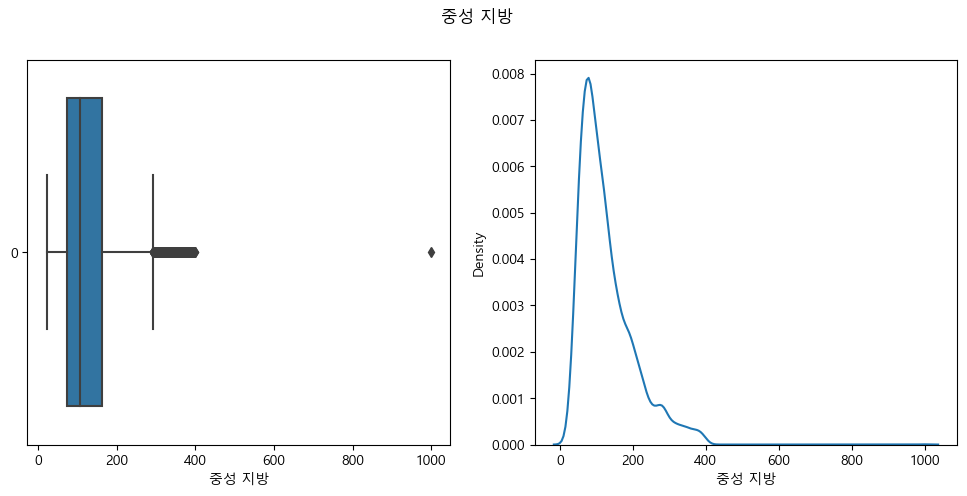

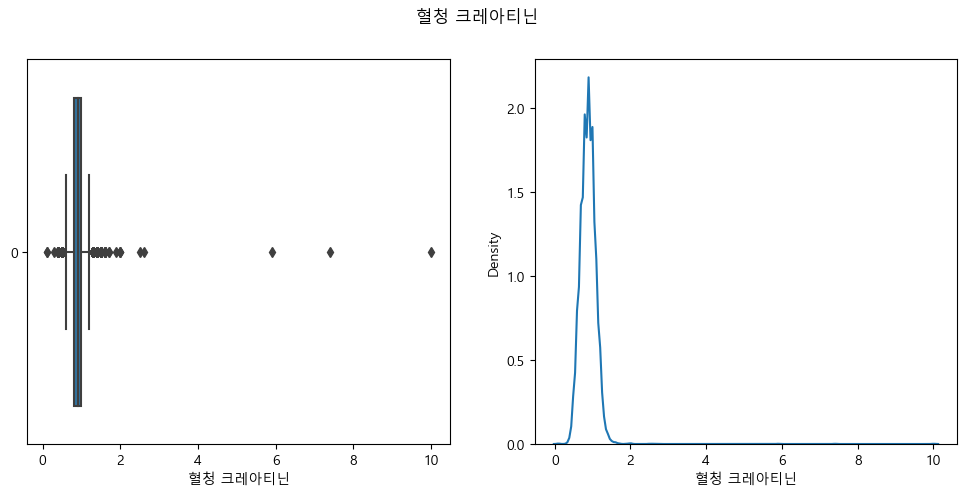

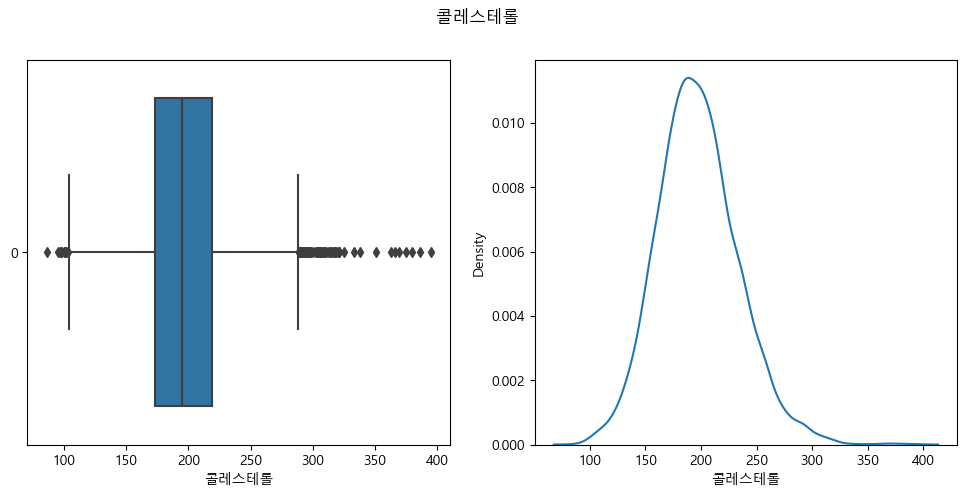

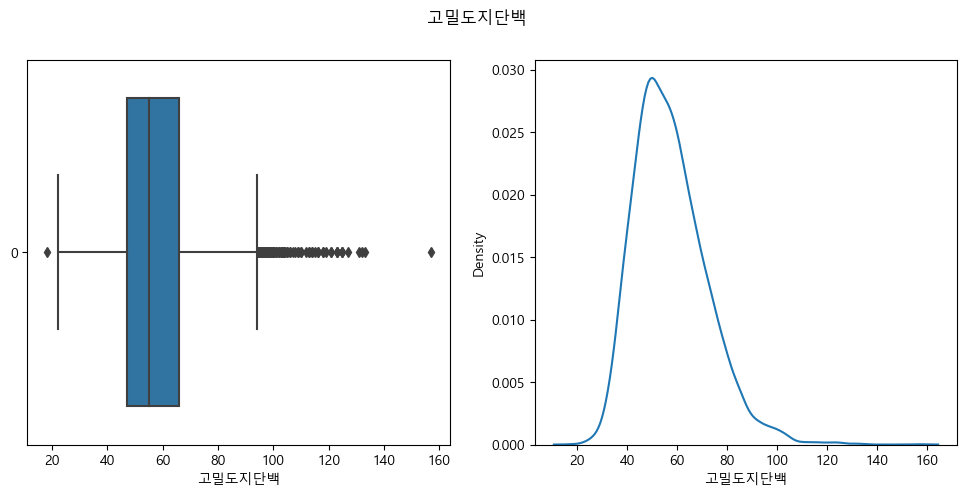

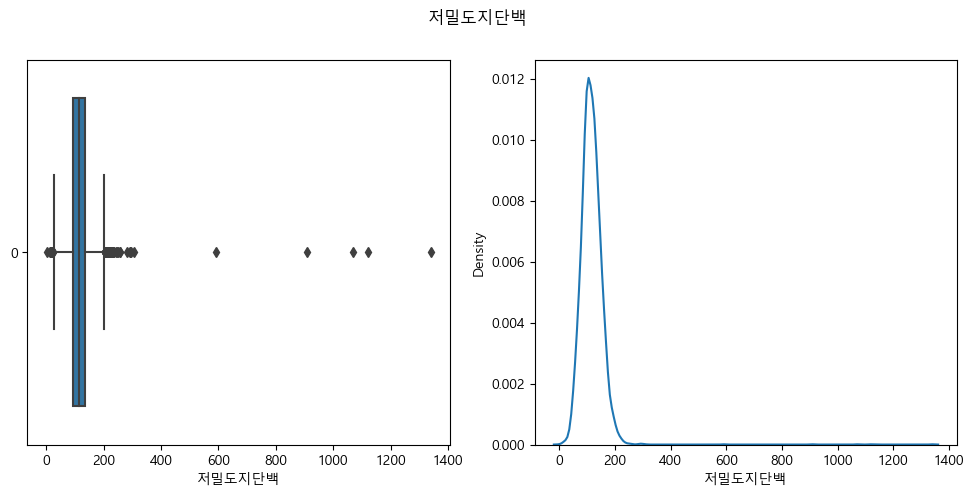

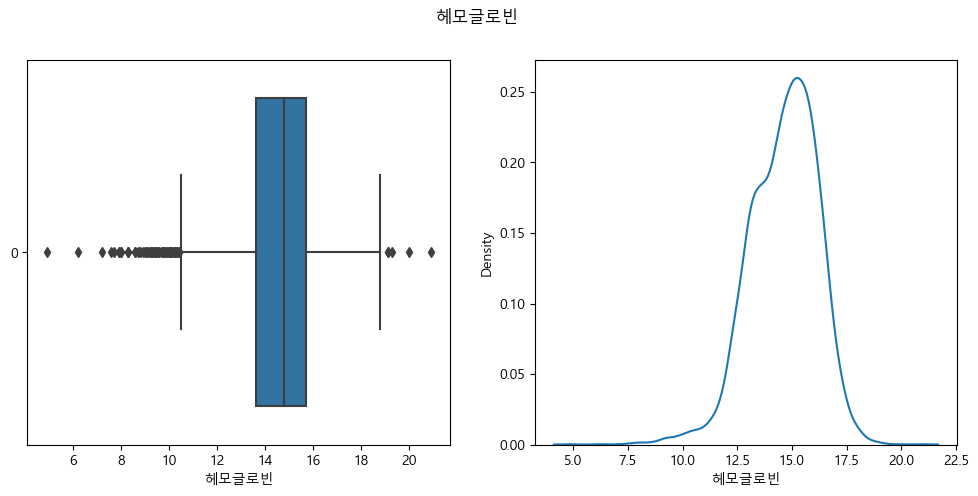

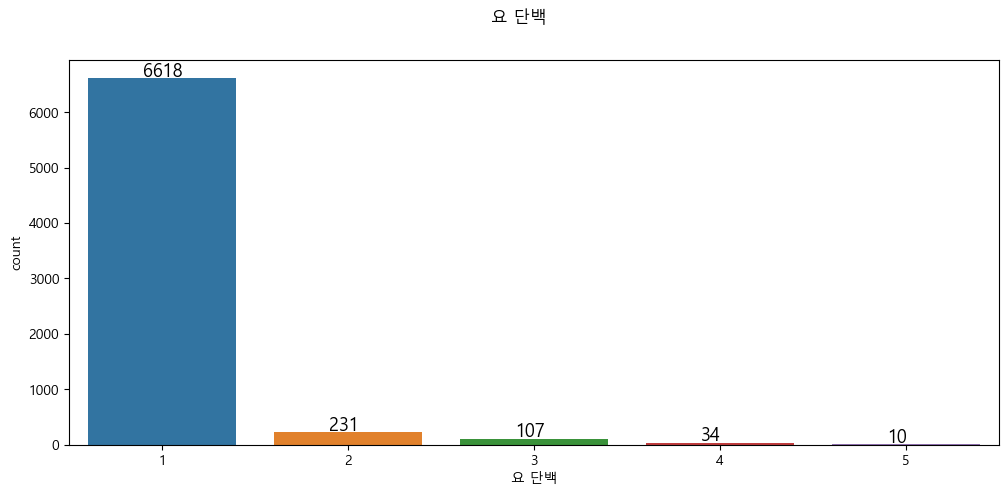

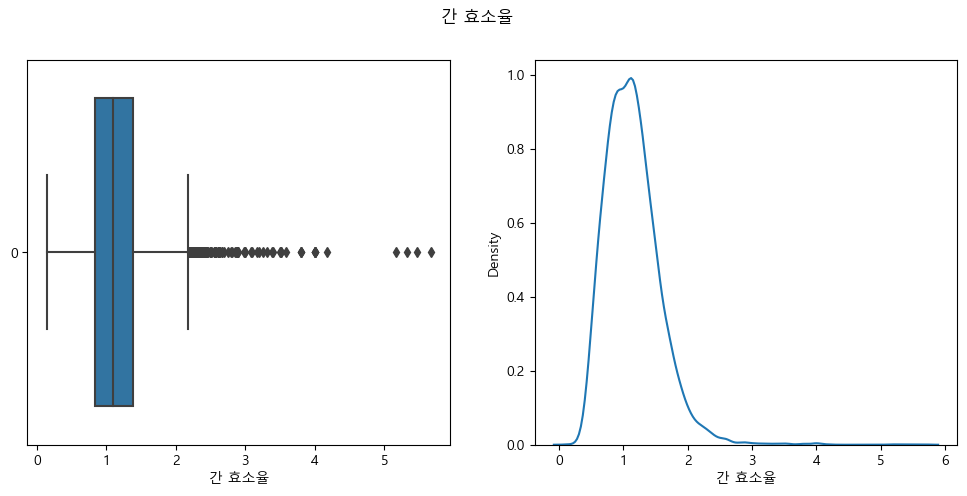

In [13]:
for idx, col in enumerate(x_train.columns):
    if x_train[col].dtype == 'category':
        fig, ax = plt.subplots(figsize=(12, 5))
        sns.countplot(x=x_train[col], ax=ax)
        for i in x_train[col].unique().sort_values():
            y = len(x_train[train[col] == i])
            if col == '요 단백':
                   i -= 1.05            
            ax.text(i-.05, y + 30, y, fontdict={'size' : 13 })
        fig.suptitle(col)
    else:    
        fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
        sns.boxplot(x_train[col], orient='h', ax=ax[0])
        sns.kdeplot(x_train[col], ax=ax[1])
        ax[0].set_xlabel(col)
        fig.suptitle(col)
    plt.show()

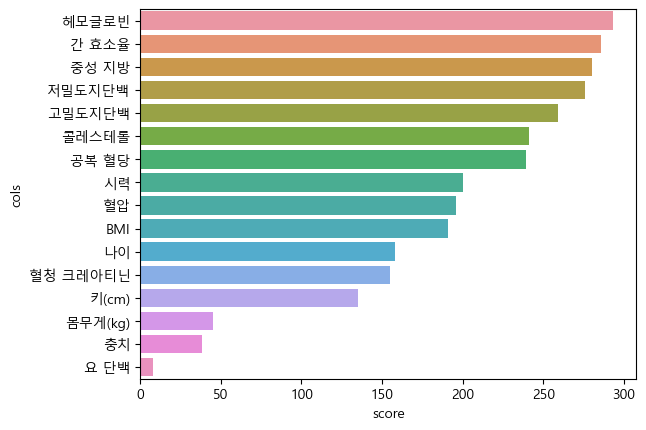

In [14]:
ftr = pd.DataFrame({'cols' : x_train.columns, 'score' : models[0].feature_importances_})
sns.barplot(x=ftr.sort_values('score', ascending=False)['score'], 
            y=ftr.sort_values('score', ascending=False)['cols'], orient='h')
plt.show()

In [15]:
# Find Outlier
def get_outliers(df, n):
    outlier_indices = []
    for col in df.columns:
        if df[col].dtypes == 'category':
            continue
        else:
            q1, q3 = np.percentile(df[col], 25), np.percentile(df[col], 75)
            iqr = q3 - q1
            outlier_step = 1.5 * iqr
        outliers = df[(df[col] < q1 - outlier_step)|(df[col]>q3 + outlier_step)].index
        outlier_indices.extend(outliers)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > n]
    return multiple_outliers

outliers = get_outliers(x_train, 2)

In [16]:
x_train.loc[outliers]

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
419,80,145,55,26.16,0.35,0,222,80,97,0.6,171,63,88,14.4,1,1.08
593,80,165,70,25.71,0.50,0,107,91,50,2.0,126,43,73,12.5,1,1.38
857,80,160,60,23.44,0.50,1,93,73,58,1.3,172,59,101,12.5,1,1.76
1099,75,155,55,22.89,0.60,0,161,68,99,1.0,117,50,47,13.7,1,0.96
1125,75,135,35,19.20,0.20,0,97,43,76,0.8,133,42,75,11.9,1,1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4202,55,165,80,29.38,1.20,0,98,60,337,0.5,317,50,199,14.9,1,0.55
5133,50,165,70,25.71,0.90,0,93,52,391,1.5,315,49,187,16.9,1,0.60
3201,40,155,55,22.89,1.20,0,89,56,39,0.5,183,65,110,10.1,1,2.20
4243,60,170,80,27.68,1.00,0,114,39,128,1.4,98,53,19,16.0,1,1.35


In [81]:
def get_base_after_score(x_train, y_train):
    _, before_score =  baseline_predict([5], save=False)
    model = LGBMClassifier(random_state=seed, verbose=2)
    after_score = cross_val_score(model, x_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=5))
    print(f'BASELINE SCORE : {np.round(np.mean(before_score), 4)}')
    print(f'AFTER SCORE : {np.round(np.mean(after_score), 4)}')

In [75]:
# 0.7271 -> 0.7234
x_train_drop_outliers = x_train.drop(outliers, axis=0)
y_train_drop_outliers = y_train.drop(outliers, axis=0)
get_base_after_score(x_train_drop_outliers, y_train_drop_outliers)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2036, number of negative: 3512
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.859229
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.107404
[LightGBM] [Debug] init for col-wise cost 0.000081 seconds, init for row-wise cost 0.000147 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 5548, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366979 -> initscore=-0.545199
[LightGBM] [Info] Start training from score -0.545199
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with

In [19]:
# 0.7366666667
baseline_predict(seeds=[5], x=x_train_drop_outliers, y=y_train_drop_outliers, file_names=['drop_outliers'])

([LGBMClassifier(random_state=42)], [[0.7267, 0.7217, 0.7116, 0.726, 0.7311]])

In [76]:
# 0.7271 -> 0.7843
smote = SMOTE(random_state=42)
x_train_oversample_smote, y_train_oversample_smote = smote.fit_resample(x_train, y_train)
get_base_after_score(x_train_oversample_smote, y_train_oversample_smote)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3543, number of negative: 3543
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.827830
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.103479
[LightGBM] [Debug] init for col-wise cost 0.000092 seconds, init for row-wise cost 0.000155 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 7086, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a

In [21]:
# 0.7455555556
baseline_predict([5], x=x_train_oversample_smote, y=y_train_oversample_smote, file_names=['oversample_smote'])

([LGBMClassifier(random_state=42)], [[0.781, 0.7872, 0.7872, 0.7922, 0.7736]])

In [77]:
# 0.7271 -> 0.7861
adasyn = ADASYN(random_state=42)
x_train_oversample_adasyn, y_train_oversample_adasyn = adasyn.fit_resample(x_train, y_train)
get_base_after_score(x_train_oversample_adasyn, y_train_oversample_adasyn)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3644, number of negative: 3544
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.827977
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.103497
[LightGBM] [Debug] init for col-wise cost 0.000097 seconds, init for row-wise cost 0.000161 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 7188, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506956 -> initscore=0.027826
[LightGBM] [Info] Start training from score 0.027826
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with l

In [78]:
# 0.7355555556
baseline_predict([5], x_train_oversample_adasyn, y_train_oversample_adasyn, ['oversample_adasyn'])

([LGBMClassifier(random_state=42)], [[0.7824, 0.7785, 0.7724, 0.7947, 0.8024]])

In [79]:
# https://givitallugot.github.io/articles/2021-07/Python-imbalanced-sampling-copy
# 0.7271 -> 0.7926
smoteto = SMOTETomek(tomek=(TomekLinks(sampling_strategy='majority')), random_state=69)
x_train_oversample_tomek, y_train_oversample_tomek = smoteto.fit_resample(x_train, y_train)
get_base_after_score(x_train_oversample_tomek, y_train_oversample_tomek)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3543, number of negative: 3361
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.827129
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.103391
[LightGBM] [Debug] init for col-wise cost 0.000104 seconds, init for row-wise cost 0.000165 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 6904, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513181 -> initscore=0.052735
[LightGBM] [Info] Start training from score 0.052735
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with l

In [63]:
# 0.7311111111
baseline_predict([5], x_train_oversample_tomek, y_train_oversample_tomek, ['oversample_tomek'])

([LGBMClassifier(random_state=42)], [[0.7856, 0.7995, 0.7914, 0.7897, 0.7966]])

In [26]:
# BMI : 18.5미만 : 저체중 / 18.5~23미만 : 정상 / 23~25미만 과체중 / 25~ 비만
# 시력 : .7~ 1.5
# 공복혈당 : 70~99 정상 / 100~125 혈당장애 / 126 : 당뇨병
# 혈압 : 60미만 / 80미만 / 90이상 -> 대부분 저혈압 -> 잘 모르겠다. 25% 이하 / 25~75% / 75% 나눠보자
# 중성지방 : 150미만 : 정상 / 150~199: 경계 / 200이상 : 위험
# 혈청 크레아티닌 : 0.5 ~ 1.1 or 1
# 콜레스테롤 : 200이하 : 적절 / 200~239 : 약간 높음 / 240 : 높음
# 고밀도지단백 : 40미만 : 낮음 / 40~60 : 정상 / 60이상 : 높음
# 저밀도지단백 : 100~129 : 정상 / 130~159 : 약간 높음 /160~189 : 높음 / 190~ 아주 높음
# 헤모글로빈 : 10이하 : 빈혈/ 12.5 - 15.5 : 정상 / 
# 요 단백 : 1 : 30 / 2:100 / 3: 300 / 4:1000 -> 300이상 : 단백뇨
# 간 효소율 : 0.8이하 : 문제 / ~1.15 정상 / 1.3~ 이상

In [81]:
x_train_fe = x_train.copy()

# Numeric 
for col1, col2 in combinations(list(x_train.select_dtypes('number')), 2):
    for op in ['+', '-', '*', '/']:
        new_col = f'{col1}_{col2}_{op}'        
        if op == '+':
            x_train_fe[new_col] = x_train[col1] + x_train[col2]
        elif op == '-':
            x_train_fe[new_col] = x_train[col1] - x_train[col2]
        elif op == '*':
            x_train_fe[new_col] = x_train[col1] * x_train[col2]
        if op == '/':
            x_train_fe[new_col] = x_train[col1] / x_train[col2]
    
    for function_name in ['min', 'max', 'mean', 'nanmedian']:
        x_train_fe[f'{col1}_{col2}_{function_name}'] = eval(f'np.{function_name}')(x_train[[col1, col2]], axis=1)

# Category
x_train_fe['BMI_bin'] = x_train_fe['BMI'].apply(lambda x : 1 if 18.5<=x<25 else 0)
x_train_fe['시력_bin'] = x_train_fe['시력'].apply(lambda x : 1 if 0.7<=x<1.5 else 0)
x_train_fe['혈압_bin'] = x_train_fe['혈압'].apply(lambda x : 1 if np.percentile(x_train['혈압'], 25)<=x<np.percentile(x_train['혈압'], 75) else 0)
x_train_fe['중성 지방_bin'] = x_train_fe['중성 지방'].apply(lambda x : 1 if x<150 else 0)
x_train_fe['혈청 크레아티닌_bin'] = x_train_fe['혈청 크레아티닌'].apply(lambda x : 1 if 0.5<=x<1 else 0)
x_train_fe['콜레스테롤_bin'] = x_train_fe['콜레스테롤'].apply(lambda x : 1 if x<200 else 0)
x_train_fe['고밀도지단백_bin'] = x_train_fe['고밀도지단백'].apply(lambda x : 1 if 40<=x<60 else 0)
x_train_fe['저밀도지단백_bin'] = x_train_fe['저밀도지단백'].apply(lambda x : 1 if 100<=x<129 else 0)
x_train_fe['헤모글로빈_bin'] = x_train_fe['헤모글로빈'].apply(lambda x : 1 if 12.5<=x<15.5 else 0)
x_train_fe['요 단백_bin'] = x_train_fe['요 단백'].apply(lambda x : 1 if x<3 else 0)
x_train_fe['간 효소율_bin'] = x_train_fe['간 효소율'].apply(lambda x : 1 if 0.8<=x<1.3 else 0)
for col in x_train_fe.columns[-11:]:
    x_train_fe[col] = x_train_fe[col].astype('category')


x_train_fe['BMI_cat'] = pd.cut(x_train_fe['BMI'], bins=[0, 18.5, 25, float('inf')], labels=[0,1,2]) 
x_train_fe['시력_cat'] = x_train_fe['시력'].apply(lambda x : 1 if 0.7<=x<=1.5 else 0)
x_train_fe['시력_cat'] = x_train_fe['시력_cat'].astype('category')
x_train_fe['혈압_cat'] = pd.cut(x_train_fe['혈압'], bins=[0, np.percentile(x_train_fe['혈압'], 25), np.percentile(x_train_fe['혈압'], 75), float('inf')], labels=[0,1,2])
x_train_fe['중성 지방_cat'] = pd.cut(x_train_fe['중성 지방'], bins=[0, 150, 200, float('inf')], labels=[0, 1, 2])
x_train_fe['혈청 크레아티닌_cat'] = x_train_fe['혈청 크레아티닌'].apply(lambda x : 0 if 0<=x<=1.1 else 1)
x_train_fe['혈청 크레아티닌_cat'] = x_train_fe['혈청 크레아티닌_cat'].astype('category')
x_train_fe['콜레스테롤_cat'] = pd.cut(x_train_fe['콜레스테롤'], bins=[0, 200, 240, float('inf')], labels=[0,1,2])
x_train_fe['고밀도지단백_cat'] = pd.cut(x_train_fe['고밀도지단백'], bins=[0, 40, 60, float('inf')], labels=[0,1,2])
x_train_fe['저밀도지단백_cat'] = pd.cut(x_train_fe['저밀도지단백'], bins=[0, 130, 160, 190, float('inf')], labels=[0,1,2,3])
x_train_fe['헤모글로빈_cat'] = pd.cut(x_train_fe['헤모글로빈'], bins=[0, 12.5, 15.5, float('inf')], labels=[0,1,2]) 
x_train_fe['요 단백_cat'] = x_train_fe['요 단백'].apply(lambda x : 1 if x>=3 else 0)
x_train_fe['요 단백_cat'] = x_train_fe['요 단백_cat'].astype('category')
x_train_fe['간 효소율_cat'] = pd.cut(x_train_fe['간 효소율'], bins=[0, 0.8, 1.3, float('inf')], labels=[0,1,2])


# Numeric * Category
for col1 in x_train_fe.select_dtypes('category').columns:
    for col2 in x_train.select_dtypes('number').columns:
        if col2 in col1:
            continue
        for op in ['mean', 'median', 'var', 'std']:
            new_col = f'{col1}_{col2}_{op}'
            x_train_fe[new_col] = x_train_fe[col1].map(x_train_fe.groupby(col1)[col2].agg(op))
            x_train_fe[new_col] = x_train_fe[new_col].astype('float')
            

In [82]:
x_train_fe

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,...,간 효소율_cat_고밀도지단백_var,간 효소율_cat_고밀도지단백_std,간 효소율_cat_저밀도지단백_mean,간 효소율_cat_저밀도지단백_median,간 효소율_cat_저밀도지단백_var,간 효소율_cat_저밀도지단백_std,간 효소율_cat_헤모글로빈_mean,간 효소율_cat_헤모글로빈_median,간 효소율_cat_헤모글로빈_var,간 효소율_cat_헤모글로빈_std
0,35,170,70,24.22,1.10,1,98,40,80,1.3,...,220.572630,14.851688,111.601687,109.0,1009.007705,31.764882,13.886598,13.9,2.447968,1.564598
1,40,150,55,24.44,1.00,0,173,39,104,0.6,...,220.572630,14.851688,111.601687,109.0,1009.007705,31.764882,13.886598,13.9,2.447968,1.564598
2,60,170,50,17.30,0.75,0,96,40,61,0.8,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201
3,40,150,45,20.00,0.50,0,92,40,46,0.7,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201
4,55,155,65,27.06,1.00,0,87,42,95,0.9,...,220.572630,14.851688,111.601687,109.0,1009.007705,31.764882,13.886598,13.9,2.447968,1.564598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,25,170,65,22.49,1.50,0,87,45,141,1.2,...,220.572630,14.851688,111.601687,109.0,1009.007705,31.764882,13.886598,13.9,2.447968,1.564598
6996,60,165,65,23.88,0.90,0,87,45,82,0.9,...,220.572630,14.851688,111.601687,109.0,1009.007705,31.764882,13.886598,13.9,2.447968,1.564598
6997,40,180,100,30.86,1.20,0,97,44,87,0.9,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201
6998,60,150,55,24.44,0.60,0,89,57,161,0.6,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201


In [83]:
get_base_after_score(x_train_fe, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2056, number of negative: 3544
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.886594
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.184076
[LightGBM] [Debug] init for col-wise cost 0.001728 seconds, init for row-wise cost 0.021444 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143471
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 1946
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367143 -> initscore=-0.544494
[LightGBM] [Info] Start training from score -0.544494
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree

In [81]:
x_test_fe = x_test.copy()

# Numeric 
for col1, col2 in combinations(list(x_test.select_dtypes('number')), 2):
    for op in ['+', '-', '*', '/']:
        new_col = f'{col1}_{col2}_{op}'        
        if op == '+':
            x_test_fe[new_col] = x_test[col1] + x_test[col2]
        elif op == '-':
            x_test_fe[new_col] = x_test[col1] - x_test[col2]
        elif op == '*':
            x_test_fe[new_col] = x_test[col1] * x_test[col2]
        if op == '/':
            x_test_fe[new_col] = x_test[col1] / x_test[col2]
    
    for function_name in ['min', 'max', 'mean', 'nanmedian']:
        x_test_fe[f'{col1}_{col2}_{function_name}'] = eval(f'np.{function_name}')(x_test[[col1, col2]], axis=1)

# Category
x_test_fe['BMI_bin'] = x_test_fe['BMI'].apply(lambda x : 1 if 18.5<=x<25 else 0)
x_test_fe['시력_bin'] = x_test_fe['시력'].apply(lambda x : 1 if 0.7<=x<1.5 else 0)
x_test_fe['혈압_bin'] = x_test_fe['혈압'].apply(lambda x : 1 if np.percentile(x_train['혈압'], 25)<=x<np.percentile(x_train['혈압'], 75) else 0)
x_test_fe['중성 지방_bin'] = x_test_fe['중성 지방'].apply(lambda x : 1 if x<150 else 0)
x_test_fe['혈청 크레아티닌_bin'] = x_test_fe['혈청 크레아티닌'].apply(lambda x : 1 if 0.5<=x<1 else 0)
x_test_fe['콜레스테롤_bin'] = x_test_fe['콜레스테롤'].apply(lambda x : 1 if x<200 else 0)
x_test_fe['고밀도지단백_bin'] = x_test_fe['고밀도지단백'].apply(lambda x : 1 if 40<=x<60 else 0)
x_test_fe['저밀도지단백_bin'] = x_test_fe['저밀도지단백'].apply(lambda x : 1 if 100<=x<129 else 0)
x_test_fe['헤모글로빈_bin'] = x_test_fe['헤모글로빈'].apply(lambda x : 1 if 12.5<=x<15.5 else 0)
x_test_fe['요 단백_bin'] = x_test_fe['요 단백'].apply(lambda x : 1 if x<3 else 0)
x_test_fe['간 효소율_bin'] = x_test_fe['간 효소율'].apply(lambda x : 1 if 0.8<=x<1.3 else 0)
for col in x_test_fe.columns[-11:]:
    x_test_fe[col] = x_test_fe[col].astype('category')

x_test_fe['BMI_cat'] = pd.cut(x_test_fe['BMI'], bins=[0, 18.5, 23, 25, float('inf')], labels=[0,1,2,3]) 
x_test_fe['시력_cat'] = x_test_fe['시력'].apply(lambda x : 1 if 0.7<=x<=1.5 else 0)
x_test_fe['시력_cat'] = x_test_fe['시력_cat'].astype('category')
x_test_fe['혈압_cat'] = pd.cut(x_test_fe['혈압'], bins=[0, np.percentile(x_train_fe['혈압'], 25), np.percentile(x_train_fe['혈압'], 75), float('inf')], labels=[0,1,2])
x_test_fe['중성 지방_cat'] = pd.cut(x_test_fe['중성 지방'], bins=[0, 150, 200, float('inf')], labels=[0, 1, 2])
x_test_fe['혈청 크레아티닌_cat'] = x_test_fe['혈청 크레아티닌'].apply(lambda x : 0 if 0<=x<=1.1 else 1)
x_test_fe['혈청 크레아티닌_cat'] = x_test_fe['혈청 크레아티닌_cat'].astype('category')
x_test_fe['콜레스테롤_cat'] = pd.cut(x_test_fe['콜레스테롤'], bins=[0, 200, 240, float('inf')], labels=[0,1,2])
x_test_fe['고밀도지단백_cat'] = pd.cut(x_test_fe['고밀도지단백'], bins=[0, 40, 60, float('inf')], labels=[0,1,2])
x_test_fe['저밀도지단백_cat'] = pd.cut(x_test_fe['저밀도지단백'], bins=[0, 130, 160, 190, float('inf')], labels=[0,1,2,3])
x_test_fe['헤모글로빈_cat'] = pd.cut(x_test_fe['헤모글로빈'], bins=[0, 12.5, 15.5, float('inf')], labels=[0,1,2]) 
x_test_fe['요 단백_cat'] = x_test_fe['요 단백'].apply(lambda x : 1 if x>=3 else 0)
x_test_fe['요 단백_cat'] = x_test_fe['요 단백_cat'].astype('category')
x_test_fe['간 효소율_cat'] = pd.cut(x_test_fe['간 효소율'], bins=[0, 0.8, 1.3, float('inf')], labels=[0,1,2])


# Numeric * Category
for col1 in x_test_fe.select_dtypes('category').columns:
    for col2 in x_test.select_dtypes('number').columns:
        if col2 in col1:
            continue
        for op in ['mean', 'median', 'var', 'std']:
            new_col = f'{col1}_{col2}_{op}'
            x_test_fe[new_col] = x_test_fe[col1].map(x_train_fe.groupby(col1)[col2].agg(op))
            x_test_fe[new_col] = x_test_fe[new_col].astype('float')

In [82]:
x_test_fe.select_dtypes('category')

,충치,요 단백,BMI_bin,시력_bin,혈압_bin,중성 지방_bin,혈청 크레아티닌_bin,콜레스테롤_bin,고밀도지단백_bin,저밀도지단백_bin,...,시력_cat,혈압_cat,중성 지방_cat,혈청 크레아티닌_cat,콜레스테롤_cat,고밀도지단백_cat,저밀도지단백_cat,헤모글로빈_cat,요 단백_cat,간 효소율_cat
0,1,1,1,1,1,1,1,0,1,0,...,1,1,0,0,1,1,1,1,0,2
1,0,1,1,0,0,1,1,0,0,1,...,0,2,0,0,0,2,0,0,0,1
2,0,1,0,1,0,0,1,1,1,0,...,1,0,2,0,0,1,0,1,0,2
3,0,1,0,1,1,0,1,1,1,0,...,1,1,2,0,0,1,0,1,0,1
4,0,1,1,1,0,1,0,0,0,0,...,1,2,0,0,1,2,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,1,0,1,0,1,0,0,1,0,...,1,2,0,0,1,1,1,1,0,0
2996,0,1,0,1,0,1,1,1,1,1,...,1,1,0,0,0,1,0,1,0,1
2997,1,1,1,1,0,1,0,1,0,1,...,1,0,0,0,0,2,0,1,0,1
2998,0,1,0,1,1,1,1,1,1,0,...,1,1,0,0,0,1,0,2,0,0


In [83]:
x_test_fe

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,...,간 효소율_cat_고밀도지단백_var,간 효소율_cat_고밀도지단백_std,간 효소율_cat_저밀도지단백_mean,간 효소율_cat_저밀도지단백_median,간 효소율_cat_저밀도지단백_var,간 효소율_cat_저밀도지단백_std,간 효소율_cat_헤모글로빈_mean,간 효소율_cat_헤모글로빈_median,간 효소율_cat_헤모글로빈_var,간 효소율_cat_헤모글로빈_std
0,40,165,55,20.20,0.90,1,98,47,75,0.5,...,220.572630,14.851688,111.601687,109.0,1009.007705,31.764882,13.886598,13.9,2.447968,1.564598
1,65,145,50,23.78,0.50,0,99,59,98,0.6,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201
2,40,160,75,29.30,1.00,0,105,34,232,0.6,...,220.572630,14.851688,111.601687,109.0,1009.007705,31.764882,13.886598,13.9,2.447968,1.564598
3,30,180,90,27.78,1.35,0,78,45,218,0.9,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201
4,50,155,55,22.89,0.75,0,116,67,139,1.0,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,40,170,90,31.14,0.85,0,94,60,146,1.1,...,141.255848,11.885110,121.092045,118.0,2234.766522,47.273317,15.504142,15.6,1.511989,1.229630
2996,25,175,80,26.12,1.00,0,95,50,100,0.8,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201
2997,45,155,60,24.97,1.20,1,88,32,51,0.4,...,196.328547,14.011729,115.123767,113.0,1971.483481,44.401391,14.710792,14.9,2.014133,1.419201
2998,35,175,90,29.39,1.35,0,94,42,142,0.8,...,141.255848,11.885110,121.092045,118.0,2234.766522,47.273317,15.504142,15.6,1.511989,1.229630


In [46]:
model, score = baseline_predict([5], x_train_fe, y_train, save=False, file_names=['fe_bin_cat'])

[0.7307]


In [86]:
submission['label'] = model[0].predict(x_test_fe)
submission.to_csv('data/preprocess/submission_fe_bin_cat.csv', index=False)

In [76]:
smote = SMOTE(random_state=42)
x_train_oversample_smote_fe, y_train_oversample_smote_fe = smote.fit_resample(x_train_fe, y_train)
get_base_after_score(x_train_oversample_smote_fe, y_train_oversample_smote_fe)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3543, number of negative: 3543
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.822900
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.250966
[LightGBM] [Debug] init for col-wise cost 0.002698 seconds, init for row-wise cost 0.028789 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178552
[LightGBM] [Info] Number of data points in the train set: 7086, number of used features: 1408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Tra

In [77]:
model, score = baseline_predict([5], x_train_oversample_smote_fe, y_train_oversample_smote_fe, save=False, file_names=['smote_fe'])

In [78]:
submission['label'] = model[0].predict(x_test_fe)
submission.to_csv('data/preprocess/submission_smote_fe.csv', index=False)

In [79]:
train

,ID,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율,label
0,TRAIN_0000,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53,1
1,TRAIN_0001,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45,0
2,TRAIN_0002,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04,0
3,TRAIN_0003,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18,0
4,TRAIN_0004,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,TRAIN_6995,25,170,65,22.49,1.50,0,87,45,141,1.2,184,44,112,14.9,1,1.50,0
6996,TRAIN_6996,60,165,65,23.88,0.90,0,87,45,82,0.9,184,64,103,14.3,1,1.47,1
6997,TRAIN_6997,40,180,100,30.86,1.20,0,97,44,87,0.9,178,54,107,15.6,1,1.00,0
6998,TRAIN_6998,60,150,55,24.44,0.60,0,89,57,161,0.6,157,49,76,14.4,1,1.00,0


In [80]:

predictor = TabularPredictor(label='label', eval_metric='accuracy').fit(
    train_data= train.drop('ID', axis=1), time_limit=3600*3, presets='best_quality',
    num_bag_folds=5, num_stack_levels=3
)


No path specified. Models will be saved in: "AutogluonModels\ag-20230821_113416\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "AutogluonModels\ag-20230821_113416\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   830.50 GB / 1000.19 GB (83.0%)
Train Data Rows:    7000
Train Data Columns: 16
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, clas

In [81]:
submission['label'] = predictor.predict(x_test)
submission.to_csv('data/preprocess/submission_autogluon_nothing_3hour.csv', index=False)

In [145]:
predictor = TabularPredictor(label='label', problem_type='binary', eval_metric='accuracy', path='autogluon_tomek').fit(
    train_data = pd.concat([x_train_oversample_tomek, y_train_oversample_tomek], axis=1),
    time_limit= 3600*3,
    presets='best_quality',
    num_cpus = 6,
    num_gpus=1,
    auto_stack=True,
    num_bag_folds = 5,
    num_stack_levels=5,
)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=5, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "autogluon_tomek\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   827.55 GB / 1000.19 GB (82.7%)
Train Data Rows:    8630
Train Data Columns: 16
Label Column: label
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22556.06 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generato

In [146]:
submission['label'] = predictor.predict(x_test)
submission.to_csv('data/preprocess/submission_autogluon_tomek_3hour.csv', index=False)

In [147]:
predictor.leaderboard()

                      model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L4   0.862804      13.253934  4595.363126                0.007001           1.193281            4       True         38
1       WeightedEnsemble_L7   0.862804      24.488590  9582.333535                0.007002           1.188280            7       True         74
2       WeightedEnsemble_L5   0.862688      17.877480  6642.831048                0.007002           1.194280            5       True         50
3           CatBoost_BAG_L3   0.862572      12.929035  4488.109200                0.162034         448.829987            3       True         31
4       WeightedEnsemble_L3   0.862109      10.814707  3580.674808                0.007001           1.194768            3       True         26
5           LightGBM_BAG_L4   0.862109      17.212459  6081.789927                0.208050          95.767726            4       T

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L4,0.862804,13.253934,4595.363126,0.007001,1.193281,4,True,38
1,WeightedEnsemble_L7,0.862804,24.488590,9582.333535,0.007002,1.188280,7,True,74
2,WeightedEnsemble_L5,0.862688,17.877480,6642.831048,0.007002,1.194280,5,True,50
3,CatBoost_BAG_L3,0.862572,12.929035,4488.109200,0.162034,448.829987,3,True,31
4,WeightedEnsemble_L3,0.862109,10.814707,3580.674808,0.007001,1.194768,3,True,26
...,...,...,...,...,...,...,...,...,...
69,CatBoost_BAG_L1,0.788876,0.104023,747.640184,0.104023,747.640184,1,True,7
70,NeuralNetTorch_BAG_L1,0.788760,0.362932,379.203777,0.362932,379.203777,1,True,12
71,NeuralNetFastAI_BAG_L1,0.786906,0.657564,183.884433,0.657564,183.884433,1,True,10
72,KNeighborsDist_BAG_L1,0.784241,0.079094,0.023006,0.079094,0.023006,1,True,2


In [149]:
predictor = TabularPredictor(label='label', problem_type='binary', eval_metric='accuracy', path='autogluon_smote').fit(
    train_data = pd.concat([x_train_oversample_smote, y_train_oversample_smote], axis=1),
    time_limit= 3600*3,
    presets='best_quality',
    num_cpus = 6,
    num_gpus=1,
    auto_stack=True,
    num_bag_folds = 5,
    num_stack_levels=5,
)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=5, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "autogluon_smote\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   825.11 GB / 1000.19 GB (82.5%)
Train Data Rows:    8858
Train Data Columns: 16
Label Column: label
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    21171.92 MB
	Train Data (Original)  Memory Usage: 1.01 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generato

In [150]:
submission['label'] = predictor.predict(x_test)
submission.to_csv('data/preprocess/submission_autogluon_smote_3hour.csv', index=False)

In [ ]:
x_test.drop(['요 단백', '충치', '몸무게(kg)'], axis=1)

In [62]:
predictor = TabularPredictor(label='label', problem_type='binary', eval_metric='accuracy', path='autogluon_no_3_2').fit(
    train_data = pd.concat([x_train.drop(['요 단백', '충치', '몸무게(kg)'], axis=1), y_train], axis=1),
    time_limit= 3600*6.5,
    presets='best_quality',
    num_cpus = 6,
    num_gpus=1,
    auto_stack=True,
    num_bag_folds = 5,
    num_stack_levels=5,
)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=5, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "autogluon_no_3\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   822.46 GB / 1000.19 GB (82.2%)
Train Data Rows:    7000
Train Data Columns: 13
Label Column: label
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    26686.93 MB
	Train Data (Original)  Memory Usage: 0.73 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generator

In [64]:
# 0.762
submission['label'] = predictor.predict(x_test.drop(['요 단백', '충치', '몸무게(kg)'], axis=1))
submission.to_csv('data/preprocess/submission_autogluon_no3_3hour_2.csv', index=False)

In [72]:
x_train

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
0,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53
1,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45
2,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04
3,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18
4,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,25,170,65,22.49,1.50,0,87,45,141,1.2,184,44,112,14.9,1,1.50
6996,60,165,65,23.88,0.90,0,87,45,82,0.9,184,64,103,14.3,1,1.47
6997,40,180,100,30.86,1.20,0,97,44,87,0.9,178,54,107,15.6,1,1.00
6998,60,150,55,24.44,0.60,0,89,57,161,0.6,157,49,76,14.4,1,1.00


In [77]:
x_train, y_train, x_test, submission = get_data()
x_train

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
0,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53
1,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45
2,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04
3,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18
4,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,25,170,65,22.49,1.50,0,87,45,141,1.2,184,44,112,14.9,1,1.50
6996,60,165,65,23.88,0.90,0,87,45,82,0.9,184,64,103,14.3,1,1.47
6997,40,180,100,30.86,1.20,0,97,44,87,0.9,178,54,107,15.6,1,1.00
6998,60,150,55,24.44,0.60,0,89,57,161,0.6,157,49,76,14.4,1,1.00


In [297]:
x_train_fe = x_train.copy()
x_train_fe.drop(['요 단백', '충치', '몸무게(kg)'], axis=1, inplace=True)

for col1, col2 in combinations(list(x_train.select_dtypes('number')), 2):
    for op in ['+', '-', '*', '/']:
        new_col = f'{col1}_{col2}_{op}'        
        if op == '+':
            x_train_fe[new_col] = x_train[col1] + x_train[col2]
        elif op == '-':
            x_train_fe[new_col] = x_train[col1] - x_train[col2]
        elif op == '*':
            x_train_fe[new_col] = x_train[col1] * x_train[col2]
        if op == '/':
            x_train_fe[new_col] = x_train[col1] / x_train[col2]
    
    for function_name in ['min', 'max', 'mean', 'nanmedian']:
        x_train_fe[f'{col1}_{col2}_{function_name}'] = eval(f'np.{function_name}')(x_train[[col1, col2]], axis=1)



In [298]:
x_test_fe = x_test.copy()
x_test_fe.drop(['요 단백', '충치', '몸무게(kg)'], axis=1, inplace=True)


for col1, col2 in combinations(list(x_test.select_dtypes('number')), 2):
    for op in ['+', '-', '*', '/']:
        new_col = f'{col1}_{col2}_{op}'        
        if op == '+':
            x_test_fe[new_col] = x_test[col1] + x_test[col2]
        elif op == '-':
            x_test_fe[new_col] = x_test[col1] - x_test[col2]
        elif op == '*':
            x_test_fe[new_col] = x_test[col1] * x_test[col2]
        if op == '/':
            x_test_fe[new_col] = x_test[col1] / x_test[col2]
    
    for function_name in ['min', 'max', 'mean', 'nanmedian']:
        x_test_fe[f'{col1}_{col2}_{function_name}'] = eval(f'np.{function_name}')(x_test[[col1, col2]], axis=1)


In [299]:
get_base_after_score(x_train_fe, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2056, number of negative: 3544
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.932560
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.013917
[LightGBM] [Debug] init for col-wise cost 0.000164 seconds, init for row-wise cost 0.007836 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151417
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 853
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367143 -> initscore=-0.544494
[LightGBM] [Info] Start training from score -0.544494
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

In [300]:
model, score = baseline_predict([5], x_train_fe, y_train, x_test_fe)
print(np.mean(score))

0.7295999999999999


In [301]:
ftr = pd.DataFrame({'col' : x_train_fe.columns, 'score' : model[0].feature_importances_})
ftr.sort_values('score', ascending=False)

,col,score
207,키(cm)_헤모글로빈_*,56
470,시력_헤모글로빈_-,29
205,키(cm)_헤모글로빈_+,27
511,공복 혈당_혈청 크레아티닌_*,27
712,혈청 크레아티닌_헤모글로빈_/,24
...,...,...
364,BMI_혈청 크레아티닌_nanmedian,0
363,BMI_혈청 크레아티닌_mean,0
362,BMI_혈청 크레아티닌_max,0
361,BMI_혈청 크레아티닌_min,0


In [302]:
# drop_cols = [c for c in ftr.loc[ftr['score']==0, 'col'] if c not in x_train.columns]
drop_cols = [c for c in ftr.loc[ftr['score']<10, 'col']]
print(len(drop_cols))
x_train_fe_drop = x_train_fe.copy()
x_test_fe_drop = x_test_fe.copy()
x_train_fe_drop.drop(drop_cols, axis=1, inplace=True)
x_test_fe_drop.drop(drop_cols, axis=1, inplace=True)

741


In [286]:
x_train_fe_drop

,나이_몸무게(kg)_/,나이_BMI_+,나이_시력_*,나이_시력_/,나이_공복 혈당_+,나이_공복 혈당_*,나이_공복 혈당_/,나이_혈압_-,나이_혈압_/,나이_중성 지방_*,...,콜레스테롤_고밀도지단백_/,콜레스테롤_저밀도지단백_-,콜레스테롤_저밀도지단백_/,콜레스테롤_헤모글로빈_*,콜레스테롤_헤모글로빈_/,콜레스테롤_간 효소율_*,고밀도지단백_헤모글로빈_*,고밀도지단백_간 효소율_/,저밀도지단백_간 효소율_/,헤모글로빈_간 효소율_+
0,0.500000,59.22,38.5,31.818182,133,3430,0.357143,-5,0.875000,2800,...,2.813333,91,1.758333,3354.9,13.270440,322.83,1192.5,49.019608,78.431373,17.43
1,0.727273,64.44,40.0,40.000000,213,6920,0.231214,1,1.025641,4160,...,5.456522,67,1.364130,2961.8,21.271186,363.95,542.8,31.724138,126.896552,13.25
2,1.200000,77.30,45.0,80.000000,156,5760,0.625000,20,1.500000,3660,...,3.348837,55,1.617978,2203.2,9.411765,149.76,657.9,41.346154,85.576923,16.34
3,0.888889,60.00,20.0,80.000000,132,3680,0.434783,0,1.000000,1840,...,2.696970,68,1.618182,2385.2,13.283582,210.04,884.4,55.932203,93.220339,14.58
4,0.846154,82.06,55.0,55.000000,142,4785,0.632184,13,1.309524,5225,...,3.741935,81,1.536424,3201.6,16.811594,306.24,855.6,46.969697,114.393939,15.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.384615,47.49,37.5,16.666667,112,2175,0.287356,-20,0.555556,3525,...,4.181818,72,1.642857,2741.6,12.348993,276.00,655.6,29.333333,74.666667,16.40
6996,0.923077,83.88,54.0,66.666667,147,5220,0.689655,15,1.333333,4920,...,2.875000,81,1.786408,2631.2,12.867133,270.48,915.2,43.537415,70.068027,15.77
6997,0.400000,70.86,48.0,33.333333,137,3880,0.412371,-4,0.909091,3480,...,3.296296,71,1.663551,2776.8,11.410256,178.00,842.4,54.000000,107.000000,16.60
6998,1.090909,84.44,36.0,100.000000,149,5340,0.674157,3,1.052632,9660,...,3.204082,81,2.065789,2260.8,10.902778,157.00,705.6,49.000000,76.000000,15.40


In [287]:
get_base_after_score(x_train_fe_drop, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2056, number of negative: 3544
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000875
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.000969 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26563
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367143 -> initscore=-0.544494
[LightGBM] [Info] Start training from score -0.544494
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 

In [288]:
model1, score1 = baseline_predict([5], x_train_fe_drop, y_train, x_test_fe_drop)
print(np.mean(score1))

0.73188


In [289]:
predictor = TabularPredictor(label='label', problem_type='binary', eval_metric='accuracy', path='autogluon_no_3_fe').fit(
    train_data = pd.concat([x_train_fe_drop, y_train], axis=1),
    time_limit= 3600*3,
    presets='best_quality',
    num_cpus = 4,
    num_gpus=1,
    auto_stack=True,
    num_bag_folds = 5,
    num_stack_levels=5,
)

submission['label'] = predictor.predict(x_test_fe_drop)
submission.to_csv('data/preprocess/submission_autogluon_no3_fe_3hour.csv', index=False)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=5, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "autogluon_no_3_fe\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   819.38 GB / 1000.19 GB (81.9%)
Train Data Rows:    7000
Train Data Columns: 112
Label Column: label
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    21107.76 MB
	Train Data (Original)  Memory Usage: 6.27 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Gener

KeyboardInterrupt: 

In [290]:
x_train_fe = x_train.copy()
for col1, col2 in combinations(list(x_train.select_dtypes('number')), 2):
    for op in ['+', '-', '*', '/']:
        new_col = f'{col1}_{col2}_{op}'        
        if op == '+':
            x_train_fe[new_col] = x_train[col1] + x_train[col2]
        elif op == '-':
            x_train_fe[new_col] = x_train[col1] - x_train[col2]
        elif op == '*':
            x_train_fe[new_col] = x_train[col1] * x_train[col2]
        if op == '/':
            x_train_fe[new_col] = x_train[col1] / x_train[col2]
    
    for function_name in ['min', 'max', 'mean', 'nanmedian']:
        x_train_fe[f'{col1}_{col2}_{function_name}'] = eval(f'np.{function_name}')(x_train[[col1, col2]], axis=1)


x_test_fe = x_test.copy()

for col1, col2 in combinations(list(x_test.select_dtypes('number')), 2):
    for op in ['+', '-', '*', '/']:
        new_col = f'{col1}_{col2}_{op}'        
        if op == '+':
            x_test_fe[new_col] = x_test[col1] + x_test[col2]
        elif op == '-':
            x_test_fe[new_col] = x_test[col1] - x_test[col2]
        elif op == '*':
            x_test_fe[new_col] = x_test[col1] * x_test[col2]
        if op == '/':
            x_test_fe[new_col] = x_test[col1] / x_test[col2]
    
    for function_name in ['min', 'max', 'mean', 'nanmedian']:
        x_test_fe[f'{col1}_{col2}_{function_name}'] = eval(f'np.{function_name}')(x_test[[col1, col2]], axis=1)


In [291]:
get_base_after_score(x_train_fe, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2056, number of negative: 3544
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.922054
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.015876
[LightGBM] [Debug] init for col-wise cost 0.000166 seconds, init for row-wise cost 0.008412 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151447
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 856
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367143 -> initscore=-0.544494
[LightGBM] [Info] Start training from score -0.544494
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree 

In [292]:
model, score = baseline_predict([5], x_train_fe, y_train, x_test_fe)
print(np.mean(score))

0.73316


In [293]:
ftr = pd.DataFrame({'col' : x_train_fe.columns, 'score' : model[0].feature_importances_})
ftr.sort_values('score', ascending=False)

,col,score
210,키(cm)_헤모글로빈_*,56
473,시력_헤모글로빈_-,31
208,키(cm)_헤모글로빈_+,27
803,고밀도지단백_간 효소율_/,27
466,시력_저밀도지단백_*,25
...,...,...
366,BMI_혈청 크레아티닌_mean,0
365,BMI_혈청 크레아티닌_max,0
364,BMI_혈청 크레아티닌_min,0
359,BMI_중성 지방_nanmedian,0


In [294]:
drop_cols = [c for c in ftr.loc[ftr['score']<10, 'col']]
print(len(drop_cols))
x_train_fe_drop = x_train_fe.copy()
x_test_fe_drop = x_test_fe.copy()
x_train_fe_drop.drop(drop_cols, axis=1, inplace=True)
x_test_fe_drop.drop(drop_cols, axis=1, inplace=True)

739


In [295]:
get_base_after_score(x_train_fe_drop, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2056, number of negative: 3544
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.006891
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.000954 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27627
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367143 -> initscore=-0.544494
[LightGBM] [Info] Start training from score -0.544494
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31

In [296]:
predictor = TabularPredictor(label='label', problem_type='binary', eval_metric='accuracy', path='autogluon_fe').fit(
    train_data = pd.concat([x_train_fe_drop, y_train], axis=1),
    time_limit= 3600*3.5,
    presets='best_quality',
    num_cpus = 4,
    num_gpus=1,
    auto_stack=True,
    num_bag_folds = 5,
    num_stack_levels=5,
)
# 0.762
submission['label'] = predictor.predict(x_test_fe_drop)
submission.to_csv('data/preprocess/submission_autogluon_fe_3hour.csv', index=False)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=5, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 12600.0s
AutoGluon will save models to "autogluon_fe\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   819.02 GB / 1000.19 GB (81.9%)
Train Data Rows:    7000
Train Data Columns: 117
Label Column: label
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    25442.01 MB
	Train Data (Original)  Memory Usage: 6.5 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Convertin

In [2]:
a = pd.read_csv('data/preprocess/submission_autogluon_no3_3hour.csv')
b = pd.read_csv('data/preprocess/submission_no_요단백_충치_몸무게.csv')
c = pd.read_csv('data/preprocess/submission_autogluon_nothing_3hour.csv')

In [11]:
submission = pd.read_csv('data/sample_submission.csv')
submission['label'] = (a['label'] + b['label'] + c['label'])/3

In [12]:
np.where(submission.label>0.5, 1, 0)

array([0, 0, 1, ..., 0, 1, 0])

In [13]:
submission['label'] = np.where(submission.label>0.5, 1, 0)
submission['label'] = submission['label'].astype('int')

In [15]:
# 0.76777
submission.to_csv('data/preprocess/submission_3model.csv', index=False)